# Тестовое задание

### Описание

В качестве тестового задания хотим вам дать задачу по прогнозированию победителя по картам. Для этого мы выгрузили небольшую часть нашего датасета с начала года до середины лета. В выборке находятся матчи, сыгранные на S-турнирах (турнирах самого высокого уровня) за этот период. Необходимо добиться максимальной метрики ROC-AUC на тестовой выборке. 





### Описание датасета (ссылка на датасет)<br>
В датасете вы найдете:

   

1. **train.csv** - история сыгранных карт между двумя командами. 
+ `map_id`- уникальный идентификатор сыгранной карты

+ `team1_id`- уникальный идентификатор команды

+ `team2_id`- уникальный идентификатор команды

+ `map_name`- название карты

+ `who_win` - переменная, которую хотим прогнозировать. Значение 0 означает, что победила команда **team1_id**, значение 1 - победила команда **team2_id**.


2. **players_feats.csv** - признаки игроков, взятых из статистики сайта HLTV за полугодовой период для каждого `map_id` из файлов `train.csv` и `test.csv`. То есть, одна строка является агрегацией за полгода признаков игроков команды `team_id` для карты `map_id` (если дата матча 2022-01-10, то признаки будут сумма/среднее за период с 2021-06-10 до 2022-01-09). Названия колонок состоят из номера игрока и названия метрики. Например, признак `p1_total_kills` означает суммарное количество убийств, совершенных игроком `p1` за полгода до даты карты `map_id`. Вы можете использовать эти признаки, чтобы как то оценить силу команд. Файлы `train.csv` и `players_feats.csv` можно смерджить по `train.map_id == players_feats.map_id and train.team{1|2}_id == players_feats.team_id`.
    
    
3. **test.csv** - история сыгранных карт, для которых не известен победитель



### Отправка ответов

Предполагается, что вы построите процесс валидации, используя данные `train.csv`. В качестве решения нужно прислать на почту demand-sunnier0k@icloud.com свои ФИО и ссылку на github репозиторий
с решением тестового задания. Свои прогнозы для `test.csv` можете загрузить в репозиторий. 

**Дедлайн для ответов:** `16:00 мск 10 декабря`


## Ограничения

Разрешено иметь до 3 файлов с прогнозами для `test.csv`. Если файлов будет больше, из них выберется случайно 3.
Важно, чтобы была воспроизводимость результата, то есть чтобы была возможность заново прогнать эксперимент и получить такие же прогнозы (ну или почти такие же).

### Помощь

По любым техническим вопросам можете писать на почту demand-sunnier0k@icloud.com. 


## 1. Load the data and merging

In [1]:
# import modules
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

In [2]:
train = pd.read_csv('dataset/train.csv')
train.head()

,map_id,team1_id,team2_id,map_name,who_win
0,289,6665,7718,Ancient,0
1,715,4411,10577,Inferno,0
2,157,11251,9455,Nuke,1
3,524,4608,7532,Mirage,0
4,404,8637,6667,Overpass,1


In [3]:
players_feats = pd.read_csv('dataset/players_feats.csv')
players_feats.head()

,p1_id,p1_total_kills,p1_headshots,p1_total_deaths,p1_kd_ratio,p1_damage_per_round,p1_grenade_damage_per_round,p1_maps_played,p1_rounds_played,p1_kills_per_round,...,p5_kill_death_difference,p5_total_opening_kills,p5_total_opening_deaths,p5_opening_kill_ratio,p5_opening_kill_rating,p5_team_win_percent_after_first_kill,p5_first_kill_in_won_rounds,team_id,map_name,map_id
0,4954,90,42.2,112,0.80,76.3,5.9,6,156,0.58,...,5,25,12,2.08,1.28,84.0,25.0,6665,Ancient,635
1,5794,45,60.0,57,0.79,82.3,10.9,3,68,0.66,...,96,54,34,1.59,1.17,70.4,16.7,7532,Ancient,635
2,4954,156,51.9,167,0.93,63.5,3.4,10,265,0.59,...,22,26,19,1.37,1.10,88.5,20.5,6665,Dust2,583
3,5794,449,53.5,427,1.05,86.7,13.1,23,618,0.73,...,104,62,49,1.27,1.10,79.0,17.4,7532,Dust2,583
4,7998,173,32.9,130,1.33,82.4,2.9,9,225,0.77,...,19,27,25,1.08,1.08,81.5,16.2,4608,Dust2,439


In [4]:
test = pd.read_csv('dataset/test.csv')
test.head()

,index,map_id,team1_id,team2_id,map_name
0,713,309,5973,5752,Dust2
1,714,541,5973,5752,Vertigo
2,715,1,8297,7020,Nuke
3,716,392,8297,7020,Mirage
4,717,684,8297,7020,Overpass


### 1.1  Train merging

In [5]:
players_feats = players_feats.add_prefix('team1_')
train_temp = pd.merge(train, players_feats, how='inner', 
                      left_on=['map_id','team1_id', 'map_name'], 
                      right_on = ['team1_map_id','team1_team_id', 'team1_map_name'])
players_feats.columns = players_feats.columns.str.replace("team1_", "")

In [6]:
players_feats = players_feats.add_prefix('team2_')
train_temp = pd.merge(train_temp, players_feats, how='inner', 
                      left_on=['map_id','team2_id', 'map_name'], 
                      right_on=['team2_map_id','team2_team_id', 'team2_map_name'])
players_feats.columns = players_feats.columns.str.replace("team2_", "")

In [7]:
train_temp.drop('team1_map_id', inplace=True, axis=1)
train_temp.drop('team1_team_id', inplace=True, axis=1)
train_temp.drop('team1_map_name', inplace=True, axis=1)

train_temp.drop('team2_map_id', inplace=True, axis=1)
train_temp.drop('team2_team_id', inplace=True, axis=1)
train_temp.drop('team2_map_name', inplace=True, axis=1)

In [8]:
train_temp.head()

,map_id,team1_id,team2_id,map_name,who_win,team1_p1_id,team1_p1_total_kills,team1_p1_headshots,team1_p1_total_deaths,team1_p1_kd_ratio,...,team2_p5_kill_death,team2_p5_kill_round,team2_p5_rounds_with_kills,team2_p5_kill_death_difference,team2_p5_total_opening_kills,team2_p5_total_opening_deaths,team2_p5_opening_kill_ratio,team2_p5_opening_kill_rating,team2_p5_team_win_percent_after_first_kill,team2_p5_first_kill_in_won_rounds
0,289,6665,7718,Ancient,0,4954,258,36.0,293,0.88,...,0.75,0.55,75,-34,21,20,1.05,1.06,76.2,19.0
1,715,4411,10577,Inferno,0,8611,178,39.3,208,0.86,...,1.43,0.78,197,90,64,25,2.56,1.39,75.0,23.3
2,157,11251,9455,Nuke,1,7938,494,52.8,397,1.24,...,0.81,0.55,101,-32,32,35,0.91,1.09,53.1,15.5
3,524,4608,7532,Mirage,0,7998,474,29.1,304,1.56,...,0.92,0.54,109,-13,15,21,0.71,0.82,73.3,7.9
4,404,8637,6667,Overpass,1,2898,217,55.8,248,0.88,...,1.17,0.72,122,26,20,10,2.00,1.01,80.0,12.4


### 1.2 Test merging

In [9]:
players_feats = players_feats.add_prefix('team1_')
test_temp = pd.merge(test, players_feats,  how='inner', 
                     left_on=['map_id','team1_id', 'map_name'], 
                     right_on = ['team1_map_id','team1_team_id', 'team1_map_name'])

In [10]:
players_feats.columns = players_feats.columns.str.replace("team1_", "")
players_feats = players_feats.add_prefix('team2_')

In [11]:
test_temp = pd.merge(test_temp, players_feats, how='inner', 
                     left_on=['map_id','team2_id', 'map_name'], 
                     right_on=['team2_map_id','team2_team_id', 'team2_map_name'])
players_feats.columns = players_feats.columns.str.replace("team2_", "")

In [12]:
test_temp.drop('team1_map_id', inplace=True, axis=1)
test_temp.drop('team1_team_id', inplace=True, axis=1)
test_temp.drop('team1_map_name', inplace=True, axis=1)

test_temp.drop('team2_map_id', inplace=True, axis=1)
test_temp.drop('team2_team_id', inplace=True, axis=1)
test_temp.drop('team2_map_name', inplace=True, axis=1)
test_temp.drop(['index'], axis=1, inplace=True)
test.drop('index', inplace=True, axis=1)

In [13]:
test_temp.head(5)

,map_id,team1_id,team2_id,map_name,team1_p1_id,team1_p1_total_kills,team1_p1_headshots,team1_p1_total_deaths,team1_p1_kd_ratio,team1_p1_damage_per_round,...,team2_p5_kill_death,team2_p5_kill_round,team2_p5_rounds_with_kills,team2_p5_kill_death_difference,team2_p5_total_opening_kills,team2_p5_total_opening_deaths,team2_p5_opening_kill_ratio,team2_p5_opening_kill_rating,team2_p5_team_win_percent_after_first_kill,team2_p5_first_kill_in_won_rounds
0,309,5973,5752,Dust2,7687,105,53.3,108,0.97,70.7,...,0.97,0.67,142,-5,44,33,1.33,1.24,70.5,18.9
1,541,5973,5752,Vertigo,7687,230,42.2,243,0.95,68.5,...,0.89,0.62,125,-21,44,50,0.88,1.14,77.3,21.0
2,1,8297,7020,Nuke,12521,270,42.6,334,0.81,78.9,...,1.33,0.83,17,6,3,2,1.50,1.07,66.7,15.4
3,392,8297,7020,Mirage,12521,299,40.1,318,0.94,78.4,...,0.00,0.00,0,0,0,0,0.00,0.00,0.0,0.0
4,684,8297,7020,Overpass,12521,127,42.5,139,0.91,74.9,...,1.43,0.80,13,6,4,2,2.00,1.33,100.0,25.0


### 1.3 Target 

<AxesSubplot:xlabel='who_win', ylabel='count'>

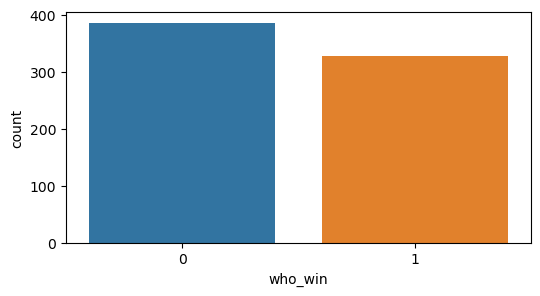

In [14]:
plt.figure(figsize=(6,3))
sns.countplot(x="who_win", data=train_temp)

There is some disbalance in data, but it `isn't too high`, so we don't need to do anything special to tackle it.

In [15]:
train_temp.shape

(713, 255)

We have `713` games, each described by map_id (game id) and `255` features.

<AxesSubplot:xlabel='map_name', ylabel='count'>

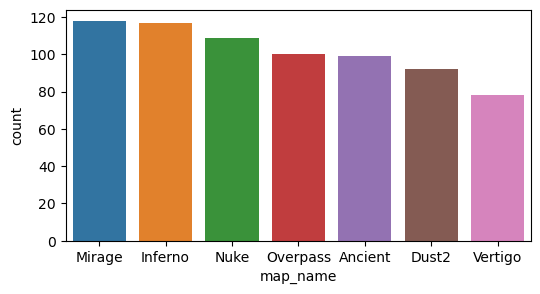

In [16]:
plt.figure(figsize=(6,3))
sns.countplot(x="map_name", data=train_temp,
              order = train_temp['map_name'].value_counts().index)

The most played maps with the most matches are `Mirage` and `Inferno`, and the least played map is `Vertigo`

In [17]:
all_features = train_temp.columns[train_temp.columns.str.contains('team1_p1_')][1:]
for i in range(len(all_features)):
    print(all_features[i].split('p1_')[1].replace('_', ' '))

total kills
headshots
total deaths
kd ratio
damage per round
grenade damage per round
maps played
rounds played
kills per round
assists per round
deaths per round
saved by teammate per round
saved teammates per round
rating
kill death
kill round
rounds with kills
kill death difference
total opening kills
total opening deaths
opening kill ratio
opening kill rating
team win percent after first kill
first kill in won rounds


`Все признаки игроков`

## 2. Feature engineering

In [18]:
# OneHot Encoding
# get dummy values for Map Name
train_temp = pd.concat([train_temp, pd.get_dummies(train_temp["map_name"], 
                                                   prefix="map_name")], axis=1)
train_temp.drop(['map_name'], axis=1, inplace=True)
test_temp = pd.concat([test_temp, pd.get_dummies(test_temp["map_name"], 
                                                 prefix="map_name")], axis=1)
test_temp.drop(['map_name'], axis=1, inplace=True)

In [19]:
null_columns = train_temp.columns[train_temp.isna().any()].tolist()

In [20]:
train_temp = train_temp.drop(null_columns, axis=1)
test_temp = test_temp.drop(null_columns, axis=1)

In [21]:
y = train_temp["who_win"]
X = train_temp.drop(labels=["who_win"], axis = 1)

In [22]:
# Удаляем все id
X = X.drop(X.filter(regex='id').columns, axis=1)

In [23]:
X.head()

,team1_p1_total_kills,team1_p1_headshots,team1_p1_total_deaths,team1_p1_kd_ratio,team1_p1_damage_per_round,team1_p1_grenade_damage_per_round,team1_p1_maps_played,team1_p1_rounds_played,team1_p1_kills_per_round,team1_p1_assists_per_round,...,team2_p5_opening_kill_ratio,team2_p5_opening_kill_rating,team2_p5_first_kill_in_won_rounds,map_name_Ancient,map_name_Dust2,map_name_Inferno,map_name_Mirage,map_name_Nuke,map_name_Overpass,map_name_Vertigo
0,258,36.0,293,0.88,71.1,6.3,17,454,0.57,0.20,...,1.05,1.06,19.0,1,0,0,0,0,0,0
1,178,39.3,208,0.86,64.1,6.5,12,320,0.56,0.14,...,2.56,1.39,23.3,0,0,1,0,0,0,0
2,494,52.8,397,1.24,94.0,5.8,22,596,0.83,0.16,...,0.91,1.09,15.5,0,0,0,0,1,0,0
3,474,29.1,304,1.56,86.9,2.4,18,531,0.89,0.09,...,0.71,0.82,7.9,0,0,0,1,0,0,0
4,217,55.8,248,0.88,64.8,4.6,14,386,0.56,0.16,...,2.00,1.01,12.4,0,0,0,0,0,1,0


In [24]:
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

## 3. Model Evaluation

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=20, 
                                                    random_state=42) #  test_size=30, random_state=70
print(X_train.shape),
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(693, 237)
(20, 237)
(693,)
(20,)


### 3.1 RandomForestClassifier

In [26]:
%%time
model = RandomForestClassifier(n_estimators=180, 
                               random_state=42)
model.fit(X_train, y_train)

Wall time: 718 ms


RandomForestClassifier(n_estimators=180, random_state=42)

In [27]:
y_pred = model.predict_proba(X_test)[:, 1]

### 3.2 ROC AUC 

In [28]:
valid_score = roc_auc_score(y_test, y_pred)
print('Validation ROC-AUC score:', valid_score)

Validation ROC-AUC score: 0.8838383838383839


In [29]:
X_test_temp = test_temp.drop(test_temp.filter(regex='id').columns, axis=1)
X_test_temp = scaler.fit_transform(X_test_temp)
y_test_pred = model.predict(X_test_temp)
test['who_win'] = y_test_pred
test

,map_id,team1_id,team2_id,map_name,who_win
0,309,5973,5752,Dust2,1
1,541,5973,5752,Vertigo,1
2,1,8297,7020,Nuke,1
3,392,8297,7020,Mirage,0
4,684,8297,7020,Overpass,0
5,85,4494,4411,Vertigo,1
6,314,4494,4411,Inferno,0
7,403,4494,4411,Mirage,0
8,125,4608,7718,Inferno,1
9,241,4608,7718,Mirage,1


## 4. Submission

In [30]:
test.to_csv('test_submission.csv', index=False)